# Project: Time Series forecasting

#### Agenda:
1) period detection.
2) variation analysis.
3) zero-variasion case.
4) nonzero-variasion case.

#### Detection seasonality.

In [12]:
import warnings
warnings.filterwarnings('ignore')

import typing as t

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 7, 5
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [2]:
FILE_PATH = "../../data/train.parquet"

SUBMISSION_PATH = "../../data/submission.csv"

In [3]:
tr = pd.read_parquet(FILE_PATH)

print(tr.shape)

subm = pd.read_csv(SUBMISSION_PATH)

(9055560, 1)


In [4]:
index_split = tr.index.str.split('_')
tr['row_num'] = index_split.str.get(0)
tr['row_type'] = index_split.str.get(1)
tr['timestamp'] = index_split.str.get(-1).astype(int)
tr['row_id'] = tr.row_num + '_' + tr.row_type

In [5]:
X = tr.pivot(index=['row_id', 'row_num', 'row_type'], columns='timestamp', values='Values')
X.columns = ['tr_' + str(col) for col in X.columns]
X.shape

(510, 17756)

In [6]:
X.head()

tr_0      tr_1      tr_2      tr_3      tr_4  \
row_id row_num row_type                                                     
0_0    0       0         133.0000  114.0000  140.0000  106.0000  117.0000   
0_1    0       1           0.0603    0.0532    0.0622    0.0452    0.0574   
0_2    0       2          65.8000   66.9000   66.8000   68.9000   67.4000   
100_0  100     0         124.0000  125.0000  127.0000  121.0000  121.0000   
100_1  100     1           0.0493    0.0475    0.0486    0.0481    0.0478   

                             tr_5      tr_6      tr_7      tr_8      tr_9  \
row_id row_num row_type                                                     
0_0    0       0         110.0000  130.0000  112.0000  115.0000   93.0000   
0_1    0       1           0.0545    0.0566    0.0606    0.0479    0.0477   
0_2    0       2          65.5000   66.4000   63.0000   67.3000   65.7000   
100_0  100     0         132.0000  124.0000  116.0000  116.0000  118.0000   
100_1  100     1           0.0496    0.0446    0.0467    0.0443    0.0494   

                         ...  tr_17746  tr_17747  tr_17748  tr_17749  \
row_id row_num row_type  ...                                           
0_0    0       0         ...  446.0000  468.0000  447.0000  443.0000   
0_1    0       1         ...    0.1498    0.1595    0.1527    0.1491   
0_2    0       2         ...   61.6000   61.7000   61.8000   62.5000   
100_0  100     0         ...  261.0000  281.0000  222.0000  254.0000   
100_1  100     1         ...    0.0873    0.0932    0.0763    0.0874   

                         tr_17750  tr_17751  tr_17752  tr_17753  tr_17754  \
row_id row_num row_type                                                     
0_0    0       0         476.0000  509.0000  462.0000  412.0000  429.0000   
0_1    0       1           0.1554    0.1643    0.1621    0.1450    0.1480   
0_2    0       2          62.4000   62.7000   62.7000   62.5000   62.3000   
100_0  100     0         284.0000  286.0000  264.0000  281.0000  288.0000   
100_1  100     1           0.0970    0.0905    0.0824    0.0915    0.0985   

                         tr_17755  
row_id row_num row_type            
0_0    0       0         430.0000  
0_1    0       1           0.1488  
0_2    0       2          61.8000  
100_0  100     0         291.0000  
100_1  100     1           0.1079  

[5 rows x 17756 columns]

# Find Period

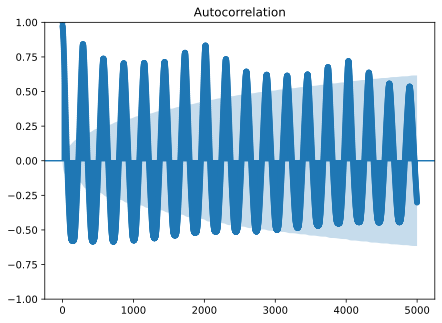

In [7]:
X_np = X.to_numpy().copy()

N = np.random.randint(170)
S = np.random.randint(3)

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(X_np[N * 3 + S,:], lags=np.arange(5000));

In [8]:
import statsmodels.api as sm

SHIFT = 100

period = np.zeros(shape=X.shape[0])
for i in range(X.shape[0]):
    acf = sm.tsa.acf(X_np[i,:], nlags=500)
    period[i] = SHIFT + np.argmax(acf[SHIFT:])
period_s = int(np.median(period))

2016

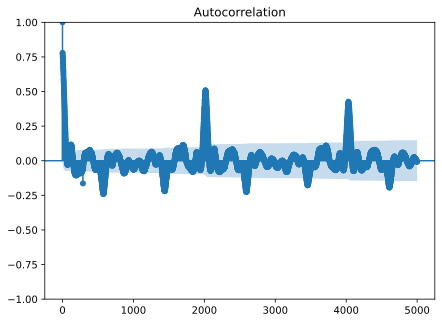

In [9]:
X_np_d = X_np[:,period_s:] - X_np[:,:-period_s] 

N = np.random.randint(170)
S = np.random.randint(3)

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(X_np_d[N * 3 + S,:], lags=np.arange(5000));

period = np.zeros(shape=X.shape[0])
for i in range(X.shape[0]):
    acf = sm.tsa.acf(X_np_d[i,:], nlags=3000)
    period[i] = SHIFT + np.argmax(acf[SHIFT:])
period_b = int(np.median(period))
period_b

In [10]:
X_np_dd = X_np_d[:,period_b:] - X_np_d[:,:-period_b] 

N = np.random.randint(170)
S = np.random.randint(3)

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(X_np_dd[N * 3 + S,:], lags=np.arange(10000));

In [16]:
PERIOD_B, PERIOD_S = period_b, period_s
period_s, period_b

(288, 2016)

# Make prediction based on periods

In [21]:
def calculate_weights(data):
    """
    weights calculation
    """
    weights = []
    for i in range(data.shape[0]):
        ts = data.values[i, :]
        weight = np.mean(np.abs(np.diff(ts)))
        weights.append(1 / weight)
    return np.array(weights)


def calculate_mase(y_true, y_pred, weight):
    """
    mase calculation
    """
    n = len(y_true)
    mase = np.sum(weight * np.abs(y_true - y_pred)) / n
    return mase

In [22]:
X_np = X.to_numpy().copy()
X_index = pd.DataFrame(list(X.index), columns=["row_id", "sensor_id", "type_id"])
weights = calculate_weights(X)

X_index_np = X_index.to_numpy()
X_index_np = X_index_np[:,1:].astype(float)
X_index_np

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       ...,
       [9., 0.],
       [9., 1.],
       [9., 2.]])

In [23]:
def make_features(target_df, featires_idx, data, data_index, shift=PERIOD_B, s=0):
    for i in range(100):
        for j in range(data.shape[0]):
            target_index = X.shape[1] - i - shift
            indexes = -np.array(featires_idx) + target_index
            r = j*100 + i + 100 * data.shape[0] * s
            target_df[r, 0] = j
            target_df[r, 1] = target_index
            target_df[r, 2:4] = data_index[j, :]
            target_df[r, 4:4 + indexes.shape[0]] = np.take(data[j,:], indexes)
            target_df[r, -3] = np.median(data[j, target_index - 3*PERIOD_B : target_index : PERIOD_B]) #median of last 3 periods
            target_df[r, -2] = data[j, target_index - PERIOD_B] # last periods
            target_df[r, -1] = data[j, target_index] # diff median and last 3 period

In [32]:
def make_dataset(data, data_index, features_idx, weights=weights):

    print("weight initial dataset ...")
    data_w = np.zeros(shape=data.shape)
    for i in range(data.shape[0]):
        data_w[i,:] = data[i,:] * weights[i]
    
    print("making train dataset ...")
    train = np.zeros(shape=(100*data.shape[0]*3, (features_idx.shape[0])*1 + 7))

    for s in range(0, 3):
        make_features(train, features_idx, data_w, data_index, shift=PERIOD_B*(s+2), s=s)

    print(f"train dataset shape: {train.shape}")

    print("making val dataset ...")
    val = np.zeros(shape=(100*data.shape[0], (features_idx.shape[0])*1 + 7))

    for s in range(1):
        make_features(val, features_idx, data_w, data_index, shift=PERIOD_B*(s+1), s=s)

    print(f"val dataset shape: {val.shape}")

    return train, val

In [67]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler


from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


def modelling(train, val, weights):
    X_train = train[:, :-1]
    y_train = train[:, -4:]

    X_val = val[:, :-1]
    y_val = val[:, -4:]

    X_train = np.hstack((X_train[:,3].reshape((X_train.shape[0], 1)), X_train[:,5:]))
    X_val = np.hstack((X_val[:,3].reshape((X_val.shape[0], 1)), X_val[:,5:]))

    X_val_ind = X_val[:,:5]

    y_true = y_val[:,-1]/np.repeat(weights, 100)
    y_pred = y_val[:,-3]/np.repeat(weights, 100)
    print(f" mase (median of last 3 periods): {calculate_mase(y_true, y_pred, np.repeat(weights, 100))}")

    y_pred = y_val[:,-2]/np.repeat(weights, 100)
    print(f" mase (last periods): {calculate_mase(y_true, y_pred, np.repeat(weights, 100))}")

    pipe = [
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())]

    pipeline = Pipeline(pipe)

    pipeline.fit(X_train, y_train[:,-1])
    y_pred = pipeline.predict(X_val)/np.repeat(weights, 100)
    print(f" LR: {calculate_mase(y_true, y_pred, np.repeat(weights, 100))}")
    y_train_pred = pipeline.predict(X_train)/np.tile(np.repeat(weights, 100), 3)
    print(f" LR train: {calculate_mase(y_train[:,-1]/np.tile(np.repeat(weights, 100), 3), y_train_pred, np.tile(np.repeat(weights, 100), 3))}")

    mms = MinMaxScaler()

    pipe_lgbm = [
        ('min_max', MinMaxScaler()),
        ('lgbm', LGBMRegressor())
    ]
    lgbm_pipeline = Pipeline(pipe_lgbm)

    lgbm_pipeline.fit(X_train, y_train[:,-1])
    y_pred = lgbm_pipeline.predict(X_val)/np.repeat(weights, 100)
    print(f" LGBM val: {calculate_mase(y_true, y_pred, np.repeat(weights, 100))}")
    y_train_pred = lgbm_pipeline.predict(X_train)/np.tile(np.repeat(weights, 100), 3)
    print(f" LGBM train: {calculate_mase(y_train[:,-1]/np.tile(np.repeat(weights, 100), 3), y_train_pred, np.tile(np.repeat(weights, 100), 3))}")

    return pipeline

In [68]:
featires_idx = []
SEQUENCE = 1
for b in range(0, 6):
    for s in range(0, 7):
        for i in range(SEQUENCE):        
            featires_idx.append(int(b * PERIOD_B + s * PERIOD_S + i))
for i in range(SEQUENCE):
    featires_idx[i] = featires_idx[i] + 100
featires_idx = np.array(featires_idx)
featires_idx.shape[0]

42

In [69]:
train, val = make_dataset(X_np, X_index_np, featires_idx, weights)

weight initial dataset ...
making train dataset ...
train dataset shape: (153000, 49)
making val dataset ...
val dataset shape: (51000, 49)


In [70]:
modelling(train, val, weights)

 mase (median of last 3 periods): 1.7033179105240053
 mase (last periods): 2.443400178260316
 LR: 1.8045440704421465
 LR train: 1.7655272944317317
 LGBM val: 1.9147133072739433
 LGBM train: 1.4703115119376622


Pipeline(steps=[('scaler', StandardScaler()), ('reg', LinearRegression())])

In [71]:
featires_idx = []
SEQUENCE = 30
for b in range(0, 6):
    for s in range(0, 7):
        num = SEQUENCE if (b + s) == 0 else 1  
        for i in range(num):        
            featires_idx.append(int(b * PERIOD_B + s * PERIOD_S + i))
for i in range(SEQUENCE):
    featires_idx[i] = featires_idx[i] + 100
featires_idx = np.array(featires_idx)
featires_idx.shape[0]

71

In [72]:
train, val = make_dataset(X_np, X_index_np, featires_idx, weights)

weight initial dataset ...
making train dataset ...
train dataset shape: (153000, 78)
making val dataset ...
val dataset shape: (51000, 78)


In [73]:
modelling(train, val, weights)

 mase (median of last 3 periods): 1.7033179105240053
 mase (last periods): 2.443400178260316
 LR: 1.8797413384488066
 LR train: 1.7846361756883566
 LGBM val: 1.9430854492029843
 LGBM train: 1.4371974910769953


Pipeline(steps=[('scaler', StandardScaler()), ('reg', LinearRegression())])

# Variance analysis

In [46]:
X_diff = X_np[:, PERIOD_B:] - X_np[:, :-PERIOD_B]

<Axes: ylabel='Count'>

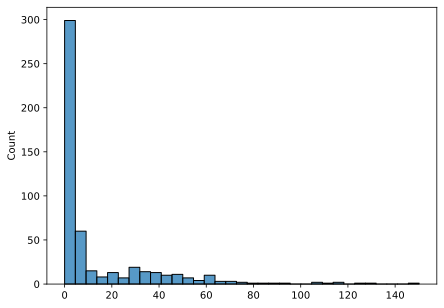

In [52]:
sns.histplot(np.std(X_diff, axis=1))

In [87]:
const_row = np.where(np.std(X_diff[:,-1000:], axis=1) == 0)[0]
const_row.shape

(102,)

### Nonzero-variance raws
Use AutoReg with period 288

In [113]:
from statsmodels.tsa.ar_model import AutoReg

from tqdm import tqdm

X_train = X.to_numpy()[:,:-100]

res_test_arima = np.zeros(shape=(510, 100))
for i in tqdm(range(510)):
    y_train = X_train[i,:]
    model = AutoReg(y_train, period=288, lags=300)
    model_fit = model.fit()
    predictions = model_fit.predict(start=X_train.shape[1], end=X_train.shape[1]+99, dynamic=False)
    res_test_arima[i,:] = predictions

100%|██████████| 510/510 [04:08<00:00,  2.06it/s]


### Zero-variance raws
use shift 2016

In [116]:
from tqdm import tqdm
res_test_shift = np.zeros(shape=(510, 100))
res_test_shift[:,:] = X_train[:,-2016:-2016 + 100]

### Join approaches

In [117]:
res_test = np.zeros(shape=(510, 100))
for i in tqdm(range(510)):
    if i in const_row:
        res_test[i,:] = res_test_shift[i,:]
    else:
        res_test[i,:] = res_test_arima[i,:]

100%|██████████| 510/510 [00:00<00:00, 102036.59it/s]


In [118]:
print(f"mase : {calculate_mase(res_test.reshape(510*100), X_np[:,-100:].reshape(510*100), np.repeat(weights, 100))}")
print(f"mase baseline: {calculate_mase(res_test_shift.reshape(510*100), X_np[:,-100:].reshape(510*100), np.repeat(weights, 100))}")

mase : 1.7806282372254802
mase baseline: 1.7455170946888532


# Final prediction

In [120]:
res_arima = np.zeros(shape=(510, 100))
for i in tqdm(range(510)):
    y_train = X_np[i,:]
    model = AutoReg(y_train, period=288, lags=300)
    model_fit = model.fit()
    predictions = model_fit.predict(start=X_train.shape[1], end=X_train.shape[1]+99, dynamic=False)
    res_arima[i,:] = predictions

100%|██████████| 510/510 [03:42<00:00,  2.29it/s]


In [115]:
res_shift = np.zeros(shape=(510, 100))
res_shift[:,:] = X_np[:,-2016:-2016 + 100]

In [121]:
res = np.zeros(shape=(510, 100))
for i in tqdm(range(510)):
    if i in const_row:
        res[i,:] = res_shift[i,:]
    else:
        res[i,:] = res_arima[i,:]

100%|██████████| 510/510 [00:00<00:00, 101740.55it/s]


In [125]:
res = res.reshape((1, -1))
row_ind = [i[0] for i in X.index]
sens_indx = np.repeat(row_ind, 100)
res = res.T
t_ind = np.tile([i for i in range(100)], 510)
ind = [i[0]+"_"+str(i[1]) for i in zip(sens_indx, t_ind)]
res = [[ind[i], res[i][0]] for i in range(51000)]

pd.DataFrame(res, columns=["Id","Expected"]).to_csv("res_arima.csv", index=False)